# 第三次讀書會報告-Bert

組別:第9組

Date:2024/05/07

# 1.載入環境及安裝套件

In [43]:
import pandas as pd
import jieba
import jieba.analyse
import re
import numpy as np
from collections import defaultdict
import multiprocessing

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, KeyedVectors

from gensim.models import Word2Vec

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns
import torch
sns.set_style("darkgrid")

import re
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

In [57]:
# 設定圖的字體大小
plt.rcParams['font.size'] = 14

# 設定中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms']
#plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus']=False

#圖型相關設定
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 120

# 2.分類任務
此處先導入Bert模型，便於後續使用bert-base-chinese模型對新聞資料集做embeddings並訓練分類器

In [2]:
from sentence_transformers import SentenceTransformer, models, util

In [3]:
# 採用中文 bert-base-chinese
bert_ch = SentenceTransformer('google-bert/bert-base-chinese')

bert_ch.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

No sentence-transformers model found with name google-bert/bert-base-chinese. Creating a new one with MEAN pooling.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

0

# 3.資料前處理

## 3.1資料蒐集
本小組自Tarflow下載Dacrd上4個個版的文章資料集，並執行程式合成一個資料集，共3,598筆資料。

其內容包含system_id、ataSource、artUrl、artDate、artTitle、artContent、boardID(文章所屬個版)、
commentCount(評論次數)、department、gender、school等欄位。

Data includes:
*   Dcard文章 from 2024/03/01 - 2024/03/25
*   專版包含以下4板：
*   穿搭版
*   星座版
*   理財版
*   研究所版

資料來源:https://tarflow.mis.nsysu.edu.tw/login?next=%2Fmain%2F662d88ed73

In [27]:
##讀取資料集
bert_travel_df = pd.read_csv("./2024_study_group9_3/raw_data/dcard_dataset/dcard_set.csv")
bert_travel_df

,system_id,dataSource,artUrl,artDate,artTitle,artContent,boardID,commentCount,department,gender,school
0,1,Dcard,https://www.dcard.tw/f/dressup/p/255078442,2024-03-25 16:18:42,#分享 150の近期日常裙裝穿搭🌸🧸 #穿出我的日系風格,https://megapx.dcard.tw/v1/images/e6ee0893-3a7...,dressup,40,ruuuuu___,F,まる🐻
1,2,Dcard,https://www.dcard.tw/f/dressup/p/255078768,2024-03-25 16:54:35,穿出我的日系風格,\麵包超人/\n因為本身長相無優勢\n所以決定用麵包超人的型態出場🤩✨\n窮超人本人真的好想...,dressup,21,clumnar,F,阿胖麵人
2,3,Dcard,https://www.dcard.tw/f/dressup/p/255078701,2024-03-25 16:45:46,#詢問 科技業女生穿搭,原本在新創公司上班，平常上班穿搭沒在管\n穿短褲、露肚臍、戴帽子 都可以\n\n但下週轉職換...,dressup,352,NaN,F,國立政治大學
3,4,Dcard,https://www.dcard.tw/f/dressup/p/255079599,2024-03-25 21:31:16,找不到李多慧的瑜伽褲品牌,NaN,dressup,3,softcindy,F,豆腐心老貓奴
4,5,Dcard,https://www.dcard.tw/f/dressup/p/255065394,2024-03-24 10:59:45,#分享 172的黑色衣櫃🐈‍⬛✨,https://megapx.dcard.tw/v1/images/61f1cb51-fb7...,dressup,24,bea.16,F,172
...,...,...,...,...,...,...,...,...,...,...,...
3593,948,Dcard,https://www.dcard.tw/f/graduate_school/p/25486...,2024-03-03 13:17:05,收王達昌經濟學研究所講義,想要自讀 有講義、小考考卷的話最好\n非常感謝,graduate_school,5,NaN,M,國立臺北大學
3594,949,Dcard,https://www.dcard.tw/f/graduate_school/p/25486...,2024-03-03 22:40:19,研究所上課方式,請教一下各位\n大家唸研究所的上課方式？\n我是第一堂課教授會講一下課程大綱、報告內容、分組...,graduate_school,11,mentalillness,F,吓聊
3595,950,Dcard,https://www.dcard.tw/f/graduate_school/p/25486...,2024-03-03 14:23:21,中興應用經濟所在職專班面試,各位好！\n本人有幸通過中興應經在職專班的第一階段審查\n想請問各位面試方面除了自我介紹外教...,graduate_school,0,volleyball123,M,白底虎斑
3596,951,Dcard,https://www.dcard.tw/f/graduate_school/p/25484...,2024-03-02 06:05:29,高雄大學 亞太工商學系 教授請益,今年考試本人正取，想請益有關高大亞太系的教授\n\n目前有興趣的教授有：\n1.許博翔 教授...,graduate_school,1,NaN,M,國立聯合大學


In [28]:
# 過濾 nan 的資料
# bert_travel_df = bert_travel_df.dropna(subset=['artTitle'])
# bert_travel_df = bert_travel_df.dropna(subset=['artContent'])
#資料集中可能有等於0或是NaN的值，故用索引選擇不等於0且不是NaN的值，接著使用dropna()方法刪除NaN的行
bert_travel_df = bert_travel_df[(bert_travel_df !=0) & (bert_travel_df.notna())].dropna()

bert_travel_df = bert_travel_df.rename(columns={'boardID':'artCatagory'})
# 移除網址格式
bert_travel_df["artContent"] = bert_travel_df.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
bert_travel_df["artTitle"] = bert_travel_df["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
bert_travel_df["artContent"] = bert_travel_df.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
bert_travel_df["artTitle"] = bert_travel_df["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)

# 留下 content
bert_travel_df["content"] = bert_travel_df["artTitle"] + bert_travel_df["artContent"]
bert_travel_df = bert_travel_df[["content", "artUrl", "artCatagory"]]  #留下文章內容、文章連結與文章種類
bert_travel_df.head()

,content,artUrl,artCatagory
0,分享近期日常裙裝穿搭穿出我的日系風格大家好我是身高體重很喜歡裙裝所以衣櫃裡幾乎找不到褲子照片...,https://www.dcard.tw/f/dressup/p/255078442,dressup
1,穿出我的日系風格麵包超人因為本身長相無優勢所以決定用麵包超人的型態出場窮超人本人真的好想獲得...,https://www.dcard.tw/f/dressup/p/255078768,dressup
4,分享的黑色衣櫃哈囉大家好久不見竟然隔了兩年風格跟以前好像轉變蠻大的現在都穿深色系為主簡單又搭...,https://www.dcard.tw/f/dressup/p/255065394,dressup
6,分享小隻女孩近期最愛的件日牌洋裝分享嗨嗨我是寧這次想來和大家分享我最近新入手的日牌洋裝們果然...,https://www.dcard.tw/f/dressup/p/255047494,dressup
7,分享挑戰可甜可鹽種穿搭哈囉大家好我是草莓奶昔平常都在美妝版出沒的我今天要來分享套可甜可鹹的穿...,https://www.dcard.tw/f/dressup/p/255065466,dressup


In [32]:
#將artCatagory從英文轉中文
bert_travel_df["artCatagory"] = bert_travel_df["artCatagory"].replace('dressup','穿搭')
bert_travel_df["artCatagory"] = bert_travel_df["artCatagory"].replace('horoscopes','星座')
bert_travel_df["artCatagory"] = bert_travel_df["artCatagory"].replace('money','理財')
bert_travel_df["artCatagory"] = bert_travel_df["artCatagory"].replace('graduate_school','研究所')
bert_travel_df

,content,artUrl,artCatagory
0,分享近期日常裙裝穿搭穿出我的日系風格大家好我是身高體重很喜歡裙裝所以衣櫃裡幾乎找不到褲子照片...,https://www.dcard.tw/f/dressup/p/255078442,穿搭
1,穿出我的日系風格麵包超人因為本身長相無優勢所以決定用麵包超人的型態出場窮超人本人真的好想獲得...,https://www.dcard.tw/f/dressup/p/255078768,穿搭
4,分享的黑色衣櫃哈囉大家好久不見竟然隔了兩年風格跟以前好像轉變蠻大的現在都穿深色系為主簡單又搭...,https://www.dcard.tw/f/dressup/p/255065394,穿搭
6,分享小隻女孩近期最愛的件日牌洋裝分享嗨嗨我是寧這次想來和大家分享我最近新入手的日牌洋裝們果然...,https://www.dcard.tw/f/dressup/p/255047494,穿搭
7,分享挑戰可甜可鹽種穿搭哈囉大家好我是草莓奶昔平常都在美妝版出沒的我今天要來分享套可甜可鹹的穿...,https://www.dcard.tw/f/dressup/p/255065466,穿搭
...,...,...,...
3588,非本科系準備機械碩士在職班大家好請問非本科系想讀機械碩士在職班工作是機構工程師有機會進機械所...,https://www.dcard.tw/f/graduate_school/p/25483...,研究所
3590,是否繼續讀社工研究所不知道發這版對不對但是還是想問問就讀過研究所的各位是否該繼續就讀社工的研...,https://www.dcard.tw/f/graduate_school/p/25485...,研究所
3591,大碩高點管理學目前在考慮報企研所試聽過兩家管理學大碩趙老師的那堂試聽完全沒板書線上試聽只有那...,https://www.dcard.tw/f/graduate_school/p/25483...,研究所
3592,分享台大應數所推甄推甄分三步驟就依順序來說一上傳資料簡單來說就是把一些大學的豐功偉業上傳有按...,https://www.dcard.tw/f/graduate_school/p/25485...,研究所


In [33]:
#對新聞資料集做embeddings
bert_travel_df["embeddings"] = bert_travel_df.content.apply(lambda x: bert_ch.encode(x))
bert_travel_df.head(3)

,content,artUrl,artCatagory,embeddings
0,分享近期日常裙裝穿搭穿出我的日系風格大家好我是身高體重很喜歡裙裝所以衣櫃裡幾乎找不到褲子照片...,https://www.dcard.tw/f/dressup/p/255078442,穿搭,"[0.55711603, -0.032540217, -0.27904975, 0.2053..."
1,穿出我的日系風格麵包超人因為本身長相無優勢所以決定用麵包超人的型態出場窮超人本人真的好想獲得...,https://www.dcard.tw/f/dressup/p/255078768,穿搭,"[0.53978235, 0.016912445, -0.22256064, 0.19923..."
4,分享的黑色衣櫃哈囉大家好久不見竟然隔了兩年風格跟以前好像轉變蠻大的現在都穿深色系為主簡單又搭...,https://www.dcard.tw/f/dressup/p/255065394,穿搭,"[0.58262795, 0.0629923, -0.35690856, 0.2241741..."


# 4.訓練模型
本小組透過此模型來驗證分類器準確度，是否能夠運用訓練資料集來預測測試資料集文章應屬於哪個個版。

In [34]:
#訓練分類器
import numpy as np
from ast import literal_eval
     
data = bert_travel_df.copy()

X = data["embeddings"].apply(pd.Series)
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

           0         1         2         3         4         5         6    \
2995  0.544036 -0.114553 -0.254055  0.304676 -0.274945 -0.259385 -0.053200   
3454  0.304661 -0.163025 -0.404008  0.410228  0.048918 -0.348916  0.193722   
318   0.537548 -0.019526 -0.270439  0.220717 -0.029577 -0.091405 -0.198395   
216   0.410029 -0.015518 -0.364993  0.095576  0.136866 -0.438125 -0.323577   
1749  0.951935  0.040194  0.205042  0.477658 -0.118777 -0.522489 -0.167639   

           7         8         9    ...       758       759       760  \
2995  0.034240 -0.261131 -0.509080  ...  0.075172 -0.175621  0.170426   
3454  0.140710 -0.342501 -0.112029  ...  0.244672  0.187137 -0.072217   
318   0.206431 -0.155904 -0.363733  ... -0.234188 -0.391149  0.172627   
216   0.266620 -0.384239 -0.361515  ... -0.002794 -0.258301  0.251896   
1749 -0.042259  0.014652 -0.041215  ...  0.153317 -0.173262  0.132129   

           761       762       763       764       765       766       767  
2995  0.238798 

In [48]:
#添加max_iter=3000避免迭代問題
clf = LogisticRegression(max_iter=3000)
clf.fit(X_train, y_train)
clf

LogisticRegression(max_iter=3000)

In [49]:
#模型預測結果
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)
print(y_pred[:10])

['研究所' '研究所' '研究所' '理財' '穿搭' '穿搭' '穿搭' '研究所' '理財' '研究所']


In [50]:
from sklearn.metrics import classification_report

#顯示Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          星座       0.96      0.98      0.97        44
          理財       0.96      0.99      0.98       100
         研究所       0.99      0.98      0.99       108
          穿搭       0.98      0.96      0.97       123

    accuracy                           0.98       375
   macro avg       0.97      0.98      0.97       375
weighted avg       0.98      0.98      0.98       375



從上表可看出無論是Accuracy, Precision, Recall還是F1-score 皆在0.96以上，可知訓練結果良好

In [51]:
classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 43,   0,   0,   1],
       [  0,  99,   0,   1],
       [  0,   2, 106,   0],
       [  2,   2,   1, 118]])

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, '星座'),
  Text(0, 1.5, '理財'),
  Text(0, 2.5, '研究所'),
  Text(0, 3.5, '穿搭')])

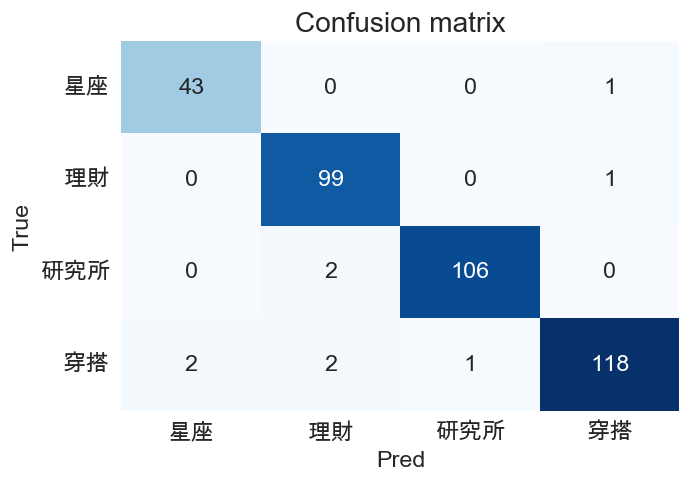

In [59]:
## Plot confusion matrix
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms']
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

透過混肴矩陣可看出，分類器準確度相當高，可以預測出PO文屬於Dcard哪個專版